In [43]:
from compute import Var, Par
from datastructures.api import Model, adda, addf, addsolver, setsolvefor, edges_no_param, addobj, addineq, OPT
from datastructures.execution import edges_from_components
from datastructures.graphutils import (namefromsympy, namefromid, dfs_tree, SOLVER, VAR, COMP, 
nested_sources, sources, edges_to_Ein_Eout, flat_graph_formulation, root_solver, 
all_edges, all_variables, copy_dicts, Node)
from datastructures.nestedgraph import build_typedgraph, root_sources
from datastructures.mergegraph import get_edges
from datastructures.execution import generate_components_and_residuals
from datastructures.workflow import get_f, order_from_tree, default_solver_options, mdao_workflow, implicit_comp_name
from datastructures.workflow_mdao import mdao_workflow_with_args
from datastructures.operators import sort_scc, reorder_merge_solve, invert_edges
from datastructures.assembly import build_archi
from datastructures.rendering import render_incidence
import openmdao.api as om
from datastructures.api import evalexpr
from constants_balloon import ρinterp, Pinterp, Ginterp, Tinterp
import numpy as np
from datastructures.postprocess import print_values_static, print_inputs, print_outputs
from datastructures.tearing import dir_graph, min_arc_set_assign, min_arc_set, min_max_scc, min_max_scc2, feedbacks
from itertools import chain
from collections import OrderedDict
import networkx as nx

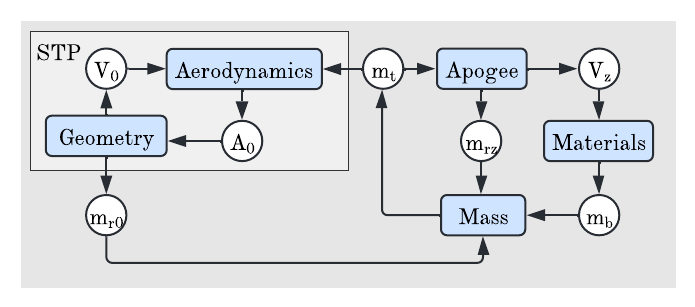

# General

In [2]:
model = Model(rootname='root')
m = model.root
idbyname = True
#m = addsolver(r)
z = Var('z', 30, unit='km')
R = Par('R', 287.05, 'J/kg/K')
alpha = Par(r'\alpha', 1)

# Apogee

In [3]:
apogee = addsolver(m, name='apogee', idbyname=idbyname)
pz = adda(apogee, 'p_z', lambda z: Pinterp(z), (z,), unit='Pa') # input assumed to be SI base (i.e. meter)
Tz = adda(apogee, 'T_z', lambda z: Tinterp(z), (z,), unit='K') # is in Kelvin already
gz = adda(apogee, 'g_z', lambda z: Ginterp(z), (z,), unit='m/s^2') # is in Kelvin already
rhoz = adda(apogee, r'\rho_z', pz/(R*Tz))
k = Par('k', 1.38064852e-23, 'J/K')
mm_He = Par('M_{He}', 6.64e-27, 'kg')
mm_H2 = Par('M_{H2}', 1.66e-27, 'kg')
rho_LGz = adda(apogee, r'\rho_{LGz}', pz*(alpha*mm_He+(1-alpha)*mm_H2)/(k*Tz))
m_t = Var('m_t', unit='kg')
W_z = adda(apogee, 'W_z', gz*m_t, unit='N')
L_z = adda(apogee, 'L_z', W_z, unit='N')
V_z = adda(apogee, 'V_z', L_z/(gz*rhoz))
mrz = adda(apogee, 'm_{rz}', V_z*rho_LGz)

# Materials

In [4]:
materials = addsolver(m, name='materials', idbyname=idbyname)
rz = adda(materials, 'r_z', (3*abs(V_z)/(4*np.pi))**(1/3), unit='m', forceunit=True)
hz = adda(materials, 'h_z', 2*(3/2)*rz)
p = Par('p', 8/5) #some parameter
S = adda(materials, 'S', 4*np.pi*(((rz**2)**p+2*abs(rz)**p*(abs(hz)/2)**p)/3)**(1/p))
t_LLDPE = Par('t_S', 25.4e-6*1, 'm')
rho_LLDPE = Par(r'\rho_S', 925, 'kg/m^3')
m_b = adda(materials, 'm_b', 2*(3/2)*S*t_LLDPE*rho_LLDPE)

# Mass budget

In [5]:
m_b = Var('m_b', unit='kg')

In [6]:
mass = addsolver(m, name='mass', idbyname=idbyname)
m_vhc = Par('m_v', 4545, 'kg')
m_parafoil = Par('m_p', 500., 'kg')
mr0 = Var('m_{r0}', unit='kg')
#m_l = adda(mass, 'm_l', lambda m1,m2: max(m1,m2), (mrz, mr0), unit='kg')
m_l = adda(mass, 'm_l', mr0, unit='kg')
adda(mass, m_t, m_vhc+m_parafoil+m_l+m_b);

# Balloon at STP

## Aerodynamics

In [7]:
aero = addsolver(m, name='aerodynamics', idbyname=idbyname)
V_0 = Var('V_0', unit='m^3')
g = Par('g', Ginterp(0), unit='m/s^2')
rho_0 = Par(r'\rho_0', ρinterp(0), 'kg/m^3')
W_0 = adda(aero, 'W_0', g*m_t, unit='N')
L_0 = adda(aero, 'L_0', g*rho_0*V_0, unit='N')
D = adda(aero, 'D', lambda L_0, W_0: max(L_0-W_0,0), (L_0,W_0), unit='N') #adda(aero, 'D', L_0-W_0, unit='N')
C_D = Par('C_D', 0.47)
vr = Var('v', 6, 'm/s')
A_0 = adda(aero, 'A_0', 2*D/(C_D*rho_0*vr**2))

## Geometry

In [8]:
geom = addsolver(m, name='geometry', idbyname=idbyname)
r_0 = adda(geom, 'r_0', 1/np.pi*abs(A_0)**0.5, unit='m')
adda(geom, V_0, 4/3*np.pi*r_0**3, unit='m^3')
rho_He = Par(r'\rho_{He}', 0.1786, 'kg/m^3')
rho_H2 = Par(r'\rho_{H2}', 0.08988, 'kg/m^3')
rho_LG0 = adda(geom, r'\rho_{LG0}', alpha*rho_He+(1-alpha)*rho_H2)
adda(geom, mr0, V_0*rho_LG0)           

m_{r0}

# Visualize model

In [9]:
nodetyperepr = {VAR: '{}', COMP: 'f_{{{}}}', SOLVER: '{}'}
edges, tree = model.generate_formulation()
edges_nopar = edges_no_param(model, edges) # filter out variables that are parameters

## HSM with modules

In [ ]:
nodetyperepr_hsm = {VAR: '{}', COMP: 'f_{{{}}}', SOLVER: '{}'}
namingfunc_hsm = namefromid(nodetyperepr_hsm)

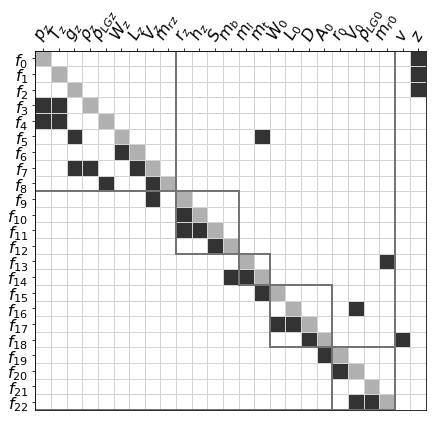

In [11]:
render_incidence(edges_nopar, tree, namingfunc_hsm, figname="balloon_hsm_init_modules.png", save=True, figsize=(7,7));

## HSM without modules

In [19]:
tree_nomod = ({key:'root' for key,val in tree[0].items()}, {},{})

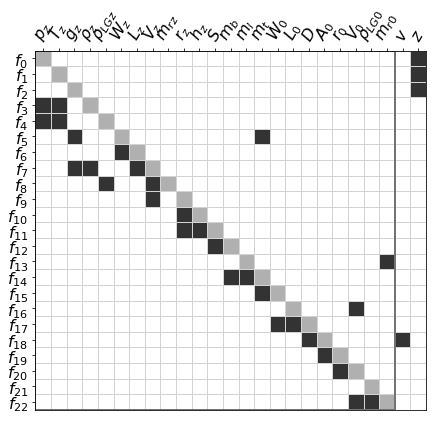

In [24]:
render_incidence(edges_nopar, tree_nomod, namingfunc_hsm, figname="balloon_hsm_init.png", save=True, figsize=(7,7));

## Graph of partitions (level 1) 

In [12]:
from representations import draw

In [13]:
graphs = build_typedgraph(edges_nopar, tree, nodetyperepr, exclude_unique_sources=False)

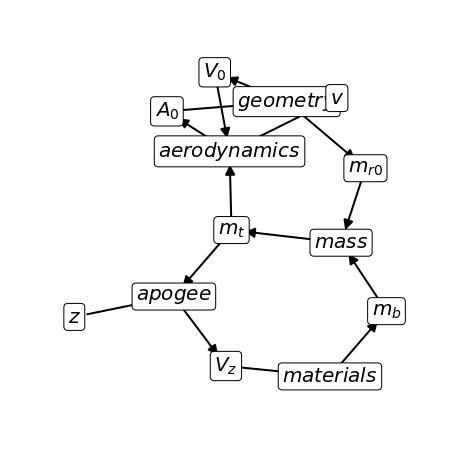

In [14]:
level = 'root'
G = graphs[level]
var_names = [elt for elt in G.nodes() if elt.nodetype==VAR]
node_shapes = {elt:'o' if elt in var_names else 's' for elt in G.nodes()}
draw(G, node_shape='b', prog='neato', latexlabels=False, figsize=(8,8));

# Rearrange for feasability

In [13]:
#l1_edges = get_edges(graphs['root'])

In [12]:
edges_for_solving = copy_dicts(edges_nopar)
eqnidxs = list(edges_for_solving[1].keys())
varidxs = all_variables(*edges_for_solving)
graph_edges_minassign = all_edges(*edges_for_solving)

In [13]:
edges_left_right = list(dir_graph(graph_edges_minassign, eqnidxs, {}))
outset_initial = {comp: var[0] for comp,var in edges[1].items()}

### HSM based on original order and feedback

In [27]:
def reformulate(edges, tree, outset_initial, new_outset=None, root_solver_name='root', mdf=True, based_on_original2=True):
    if new_outset:
        edges_new = invert_edges(edges[0], edges[1], newout=new_outset)
        tree_new = tree[0], {}, {outvar: root_solver_name for comp,outvar in outset_initial.items() if comp not in new_outset}
    else:
        edges_new = edges
        tree_new = tree
    G = flat_graph_formulation(*edges_new)
    order = sort_scc(G)
    original_comp_order = tree[0].keys()
    # This is n^2 should fix for efficiency in the future
    order_based_on_original = ([Node(comp, COMP) for comp in original_comp_order if Node(comp, COMP) in partition] for partition in order)
    order_based_on_original_2 = sorted(order_based_on_original, key=lambda x: min(idx for idx,comp in enumerate(tree[0].keys()) if Node(comp,COMP) in x))
    edges_tear_ordered, tree_tear_ordered = reorder_merge_solve(edges_new, tree_new, order_based_on_original_2, root_solver_name, mdf=mdf)
    return edges_tear_ordered, tree_tear_ordered

In [28]:
G = flat_graph_formulation(*edges_nopar, raw=True)
elimvars, elimcomps = feedbacks(G, tree_nomod[0].keys())
outset_feedbacks = {comp:outvar for comp,outvar in outset_initial.items() if comp not in elimcomps}

In [29]:
edges_feedback, tree_feedback = reformulate(edges, tree_nomod, outset_initial, mdf=True)
edges_feedback_noparam = edges_no_param(model, edges_feedback)

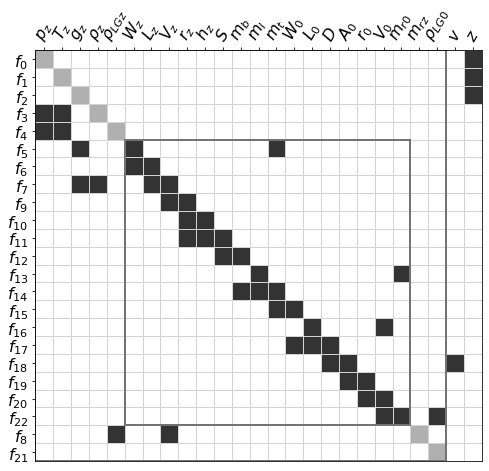

In [30]:
render_incidence(edges_feedback_noparam, tree_feedback, namingfunc_hsm, figname="balloon_hsm_minmdf.png", save=True, figsize=(8,8));

## Conventional tearing

In [31]:
cycles, elimset, m = min_arc_set(edges_left_right, outset_initial, varidxs, eqnidxs)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [32]:
new_outset = {comp:outvar for comp,outvar in outset_initial.items() if comp not in elimset}

In [33]:
edges_tear = invert_edges(edges[0], edges[1], newout=new_outset)
tree_tear = tree_nomod[0], {}, {outvar: 'root' for comp,outvar in outset_initial.items() if comp in elimset} 

In [34]:
G = flat_graph_formulation(*edges_tear)
tear_order = sort_scc(G)

In [35]:
edges_tear_ordered, tree_tear_ordered = reorder_merge_solve(edges_tear, tree_tear, tear_order, 'root', mdf=True)
edges_tear_noparam = edges_no_param(model, edges_tear_ordered)

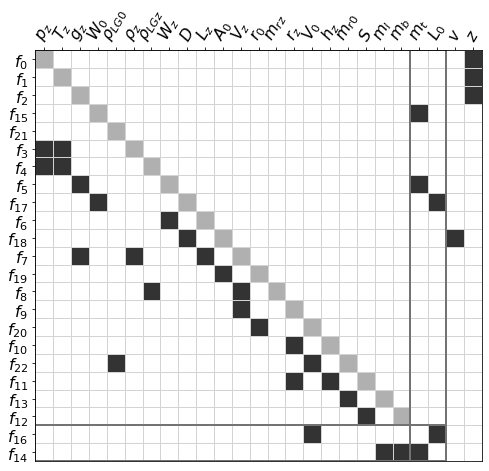

In [36]:
render_incidence(edges_tear_noparam, tree_tear_ordered, namingfunc_hsm, figname="balloon_hsm_tear.png", save=True, figsize=(8,8));

## Min tear assign

In [14]:
not_input = ['T_z','p_z','g_z',r'\rho_z', r'm_{rz}', 'm_{r0}', 'h_z', 'r_z', 'V_z', 'L_z', 'W_z', 'W_0']
not_output = []#[r'm_{rz}', 'm_{r0}']

In [15]:
min_assign_edges = edges_left_right #[(left,right) for left,right in edges_left_right if left not in varexclude and right not in compexclude]

In [16]:
xsol,mgpy = min_arc_set_assign(min_assign_edges, varidxs, eqnidxs, not_input, not_output)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [17]:
outset_minassign = dict((right, left) for left, right in edges_left_right if (left,right) in min_assign_edges and xsol[left, right] > 0.5)

In [20]:
edges_minassign = invert_edges(edges[0], edges[1], newout=outset_minassign)
tree_minassign = tree_nomod[0], {}, {outvar: 'root' for comp,outvar in outset_initial.items() if comp not in outset_minassign} 

In [21]:
G = flat_graph_formulation(*edges_minassign)
minassign_order = sort_scc(G)
edges_minassign_ordered, tree_minassign_ordered = reorder_merge_solve(edges_minassign, tree_minassign, minassign_order, 'root', mdf=True)
edges_minassign_noparam = edges_no_param(model, edges_minassign_ordered)

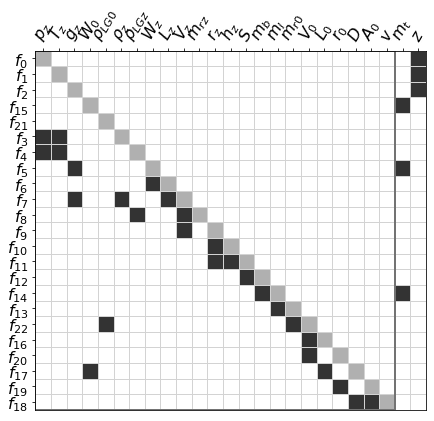

In [22]:
render_incidence(edges_minassign_noparam, tree_minassign_ordered, namingfunc_hsm, figname="balloon_hsm_minassign.png", save=True, figsize=(7,7));

### Execute

In [23]:
from datastructures.transformations import transform_components, partial_inversion, Component, var_from_mapping

In [24]:
components = model.components

In [25]:
newcomps = transform_components(edges, edges_minassign_ordered, components, model.idmapping)

In [26]:
ordered_tree = tree_minassign_ordered
ordered_edges = edges_minassign_ordered
comp_options = model.comp_options
var_options = model.var_options
solvers_options = model.solvers_options
#solvers_options['root'] = {'solver': 'GS', 'maxiter':20}
sequence = order_from_tree(ordered_tree[0], ordered_tree[1], ordered_edges[1])
solvers_options = default_solver_options(ordered_tree, solvers_options)
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)

In [27]:
nodetyperepr = model.nametyperepr
nodetyperepr[SOLVER] = '{}'
namingfunc = namefromsympy(nodetyperepr)

In [28]:
newcomps

[(('m_l',), 13, ('m_{r0}',), 'm_l'),
 (('m_b', 'm_v', 'm_t', 'm_p'), 14, ('m_l',), '-m_p - m_v - m_b + m_t'),
 (('A_0', 'C_D', 'D', '\\rho_0'), 18, ('v',), 'sqrt(2)*sqrt(D/(C_D*\\rho_0*A_0))'),
 (('r_0',), 19, ('A_0',), '9.86960440108934*r_0**2'),
 (('V_0',), 20, ('r_0',), '0.620350490899399*V_0**(1/3)'),
 (('\\rho_{LG0}', 'm_{r0}'), 22, ('V_0',), 'm_{r0}/\\rho_{LG0}')]

In [29]:
mina_components = components+newcomps
lookup_f = get_f(mina_components, ordered_edges)
wfmdao = mdao_workflow_with_args(wf, lookup_f, namingfunc)

In [30]:
prob, mdao_in, groups = build_archi(ordered_edges, ordered_tree, wfmdao, namingfunc, model.idmapping)

In [31]:
prob.set_val('m_t', 10000)

In [32]:
prob.run_model()


====
root
====
NL: Newton Converged in 0 iterations


In [139]:
allvars = all_variables(*edges_minassign)

In [144]:
print_inputs(model, prob, namingfunc, allvars, filterparam=False)

$$\rho_S$$,925,kg/m³
$$C_D$$,0.47,
$$A_0$$,1837.528,m²
$$M_{He}$$,6.640×10⁻²⁷,kg
$$v$$,7.502,m/s
$$g$$,9.807,m/s²
$$\rho_{He}$$,0.179,kg/m³
$$m_{r0}$$,1900.515,kg
$$L_z$$,9.715×10⁴,N
$$t_S$$,2.540×10⁻⁵,m
$$T_z$$,226.51,K


In [107]:
print_outputs(model, prob, namingfunc)

$$p_z$$,1197,Pa
$$T_z$$,226.51,K
$$g_z$$,9.715,m/s²
$$\rho_z$$,0.018,kg/m³
$$\rho_{LGz}$$,0.003,kg/m³
$$W_z$$,7.374×10⁴,N
$$L_z$$,7.374×10⁴,N
$$V_z$$,4.123×10⁵,m³
$$m_{rz}$$,1047.814,kg
$$r_z$$,46.171,m
$$h_z$$,138.513,m


## min scc is the same (because there is no feedback)

# Initial structure

In [86]:
ordered_tree = tree_nomod
ordered_edges = edges

## For optimization only

In [87]:
#addobj(m, m_t) # only adds component, we need to update graph

In [88]:
solvefor = [vr]#, Pcomms]

In [89]:
varoptions = {vr:[0.1,10]}# Pcomms:[10,100]}

In [90]:
Ein,Eout,Rin = copy_dicts(ordered_edges)
Ein.update({23: ('m_t',)}) 
Eout.update({23: (None,)})
ordered_edges = Ein,Eout,Rin

In [91]:
ordered_tree = (ordered_tree[0] | {23:'opt'}, {'root':'opt'}, {elt.varid:'opt' for elt in solvefor})
model.var_options = {elt.varid:var for elt,var in varoptions.items()}
model.solvers_options['opt'] = {'type': OPT, 'disp':True, 'optimizer': 'SLSQP', 'maxiter':200}

## For all runs

In [92]:
comp_options = model.comp_options
var_options = model.var_options
solvers_options = model.solvers_options
solvers_options['root'] = {'solver': 'N', 'maxiter':20, 'iprint': True}
#for elt in ['apogee', 'materials', 'mass', 'aerodynamics', 'geometry']:
#    solvers_options[elt]={'iprint': False}
sequence = order_from_tree(ordered_tree[0], ordered_tree[1], ordered_edges[1])
solvers_options = default_solver_options(ordered_tree, solvers_options)
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)

In [94]:
nodetyperepr = model.nametyperepr
nodetyperepr[SOLVER] = '{}'
namingfunc = namefromsympy(nodetyperepr)

In [95]:
components = model.components
lookup_f = get_f(components, ordered_edges)
wfmdao = mdao_workflow_with_args(wf, lookup_f, namingfunc)

In [96]:
prob, mdao_in, groups = build_archi(ordered_edges, ordered_tree, wfmdao, namingfunc, model.idmapping)

In [97]:
prob.set_solver_print(level=0)
prob.set_solver_print(level=1, depth=1)
prob.setup();

In [98]:
prob.set_val('m_t', 200)
prob.set_val('V_0', 4500)
#prob.set_val('m_r0', 1000)

In [100]:
prob.run_driver()


====
root
====
NL: Newton Converged in 1 iterations

====
root
====
NL: Newton Converged in 1 iterations


C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "



====
root
====
NL: Newton Converged in 10 iterations
Optimization terminated successfully    (Exit mode 0)
            Current function value: [9317.33211329]
            Iterations: 2
            Function evaluations: 2
            Gradient evaluations: 2
Optimization Complete
-----------------------------------


False

In [101]:
print_inputs(model, prob, namingfunc, ['v'])

$$v$$,0.1,m/s


## Results

In [102]:
print_outputs(model, prob, namingfunc, rounding=1)

$$p_z$$,1197,Pa
$$T_z$$,226.5,K
$$g_z$$,9.7,m/s²
$$\rho_z$$,0,kg/m³
$$\rho_{LGz}$$,0,kg/m³
$$W_z$$,9.1×10⁴,N
$$L_z$$,9.1×10⁴,N
$$V_z$$,5.1×10⁵,m³
$$m_{rz}$$,1286.3,kg
$$r_z$$,49.4,m
$$h_z$$,148.3,m
